In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import math as M


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/Users/flywire/Desktop/sci/dihiggsMLProject/')
from utils.commonFunctions import *

In [2]:
def trainBDT(X, y, X_val, y_val, param):

    evallist = [(X, y), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X, y.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)
    results = model.evals_result()
    ypred = model.predict(X_val)
    predictions = [round(value) for value in ypred]
    accuracy = accuracy_score(y_val, predictions)
    print("The training accuaracy is: {}".format(accuracy))
    conf_matrix = confusion_matrix(y_val, predictions)
    print("The confusion matrix: {}".format(conf_matrix))
    print("The precision is: {}".format(precision_score(y_val, predictions)))
    plot_BDTScore(X_val.copy(), y_val.copy(), model)
    return


def plot_BDTScore(X_val, y_val, model):
    sig_index = np.asarray(np.where(y_val==1))[0,:]
    bkg_index = np.asarray(np.where(y_val==0))[0,:]
    X_sig = X_val[sig_index,:]
    X_bkg = X_val[bkg_index,:]
    pred_sig = model.predict_proba(X_sig)[:,1]
    pred_bkg = model.predict_proba(X_bkg)[:,1]
    returnBestCutValue('BDT',pred_sig.copy(), pred_bkg.copy(), _testingFraction=0.3)
    plt.hist(pred_sig, bins=100, alpha=0.5, density=True, label="signal")
    plt.hist(pred_bkg, bins=100, alpha=0.5, density=True, label="background")
    plt.legend(loc="best")
    plt.title("BDT score")
    plt.show()
    
    
    
def plot_learning_curve(X, y, param, nClus):
    train_sizes, train_scores, test_scores = learning_curve(xgb.XGBClassifier(**param), X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")
    plt.legend(loc="best")
    plt.title("{} clusters learning curve".format(nClus))
    plt.show()
    
def plotCostFunc_kClus(data, nClus):
    #find out the "best" value of n_clusters to perform k-means clustering
    cost = []
    for i in range(1,nClus+1):
        ki = KMeans(n_clusters=i, random_state=0).fit(data)
        cost.append(ki.inertia_)
    plt.plot(range(1,nClus+1),cost, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('cost function')
    plt.show()
    

def KClustering(X, y, X_test, y_test, nClusters, usePCA, n_vars):
    if(usePCA):
        #process data with PCA
        #find the number of features that keep 95% variance
        print("Doing PCA...")
        variance_threshold = 0.95
        num_components = n_vars
        pca_trail = PCA()
        pca_trail.fit(X)
        var = np.cumsum(pca_trail.explained_variance_ratio_)
        for n_com in range(1,len(var)-1):
            if(var[n_com]>variance_threshold):
                num_components = n_com
                break

        print("Doing k-means clustering with {0} features...".format(num_components))
        pca = PCA(n_components=num_components)
        pca.fit(X)
        X_train_pca = pca.transform(X)
        X_test_pca = pca.transform(X_test)
        print("Shape of new training dataset: {}".format(X_train_pca.shape))
        print("Shape of new testing dataset: {}".format(X_test_pca.shape))
        #do the k-means clustering
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X_train_pca)
        score_train = kmeans.transform(X_train_pca)
        score_test = kmeans.transform(X_test_pca)
    else:
        #do k-means clustering
        print("Doing k-means clustering...")
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X)
        score_train = kmeans.transform(X)
        score_test = kmeans.transform(X_test)
        
    score_train_norm = scale(score_train)
    score_test_norm = scale(score_test)
    y_np = y.to_numpy()
    y_test_np = y_test.to_numpy()
    print("Finished clustering. :)")
    
    return score_train_norm, y_np, score_test_norm, y_test_np


#def CalcError(N_sig, N_bkg):
#    e_s = M.sqrt(N_sig)
#    e_b = (M.sqrt(N_bkg))/(2*M.sqrt(N_bkg))
#    sig = N_sig/M.sqrt(N_bkg)
#    e_sig = (N_sig/M.sqrt(N_bkg))*M.sqrt((e_s/N_sig)*(e_s/N_sig) + (e_b/M.sqrt(N_bkg))*(e_b/M.sqrt(N_bkg)))
#    return sig, e_sig
    
#print(CalcError(3621.0,1.97e+07))
#print(CalcError(1415.5,1.67e+06))
#print(CalcError(2082.7,1.61e+06))
#print(CalcError(1723.0,1.06e+06))
#print(CalcError(1206.6,4.99e+05))

In [3]:
# *** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

# *** 2. Make mix of dihiggs and QCD for specified variables
#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
#variables = ['hh_mass', 'h1_mass', 'h2_mass']
variables = list(qcd_raw.columns.values)
variables.remove('isSignal')
variables.remove('isMatchable')
remove_list = []
for var in variables:
    if((var.find('reco')!=-1) or ( (var.find('jet')!=-1) and (var.find('_')!=-1) ) ):
        remove_list.append(var)
#print(remove_list)
for r_var in remove_list:        
    variables.remove(r_var)
    
print(variables)

data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables, testingFraction)
data_train_norm = scale(data_train)
data_test_norm = scale(data_test)



['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags']
N_sig = 78876 , N_bkg = 116421
195297 rows of total data with  195297 labels [Train+Test]
136707 rows of training data with  136707 labels [Train]
58590 rows of testing data with  58590 labels [Test]


In [4]:
# *** Do the k-means clustering
#nClus = 40    # can try 15 20 40
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, False, len(variables))
#score_pcakm_train_norm,labels_train_np,score_pcakm_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
score_km_train_norm = data_train_norm
labels_train_np = labels_train.to_numpy()
score_km_test_norm = data_test_norm
labels_test_np = labels_test.to_numpy()

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.874365	validation_1-auc:0.849643
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.883208	validation_1-auc:0.856548
[2]	validation_0-auc:0.88742	validation_1-auc:0.858982
[3]	validation_0-auc:0.890004	validation_1-auc:0.860742
[4]	validation_0-auc:0.892323	validation_1-auc:0.862151
[5]	validation_0-auc:0.89473	validation_1-auc:0.863674
[6]	validation_0-auc:0.896715	validation_1-auc:0.864728
[7]	validation_0-auc:0.898646	validation_1-auc:0.866003
[8]	validation_0-auc:0.900647	validation_1-auc:0.866975
[9]	validation_0-auc:0.902264	validation_1-auc:0.867911
[10]	validation_0-auc:0.903938	validation_1-auc:0.868833
[11]	validation_0-auc:0.905275	validation_1-auc:0.869643
[12]	validation_0-auc:0.906788	validation_1-auc:0.87045
[13]	validation_0-auc:0.908292	validation_1-auc:0.871193
[14]	validation_0-auc:0.909791	validation_1-auc:0.871872
[

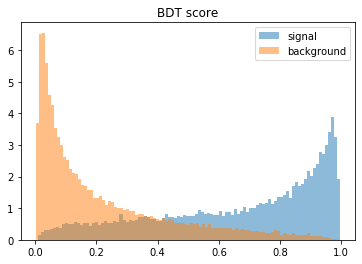

In [5]:
# *** see how the new model performs
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param_new4)

In [ ]:
#Things after this cell are parameter tuning

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.654773	validation_1-auc:0.651546
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.699351	validation_1-auc:0.699893
[2]	validation_0-auc:0.706136	validation_1-auc:0.704817
[3]	validation_0-auc:0.718572	validation_1-auc:0.717504
[4]	validation_0-auc:0.721011	validation_1-auc:0.719901
[5]	validation_0-auc:0.725248	validation_1-auc:0.725399
[6]	validation_0-auc:0.727563	validation_1-auc:0.727013
[7]	validation_0-auc:0.728195	validation_1-auc:0.72804
[8]	validation_0-auc:0.738502	validation_1-auc:0.738455
[9]	validation_0-auc:0.747917	validation_1-auc:0.747684
[10]	validation_0-auc:0.748279	validation_1-auc:0.7481
[11]	validation_0-auc:0.750769	validation_1-auc:0.750425
[12]	validation_0-auc:0.750948	validation_1-auc:0.750604
[13]	validation_0-auc:0.75174	validation_1-auc:0.751585
[14]	validation_0-auc:0.75334	validation_1-auc:0.753122
[15

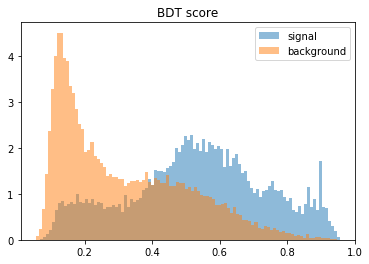

In [5]:

# *** Define parameters for BDT
param = {
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param)



In [7]:
# *** tune the classifier
# *** tune the tree parameters first
param_test1 = {
    #'max_depth': range(1,10,2),
    'max_depth': [2,3,4,5,6,7,8,9,10,11],
    'min_child_weight': range(0,6,2)
}
#cv = StratifiedKFold(5)
cv = KFold(5)
gsearch = GridSearchCV(xgb.XGBClassifier(**param), param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch.fit(score_km_train_norm, labels_train_np)
#print("The cv results: {}".format(gsearch.cv_results_))
print("The best paramter: {}".format(gsearch.best_params_))
#print("The best score: {}".format(gsearch.best_score_))

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'max_depth': 11, 'min_child_weight': 0}


In [ ]:
# *** tune tree parameters more precisely
param_test2 = {
    'max_depth': [8,9,10]
    #'min_child_weight': [1,2]
}
gsearch2 = GridSearchCV(xgb.XGBClassifier(**param), param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch2.cv_results_))
print("The best paramter: {}".format(gsearch2.best_params_))
#print("The best score: {}".format(gsearch2.best_score_))

In [10]:
# *** tune gamma
param_test3 = {
    #'gamma': [0,0.3,0.5,0.7]
    'gamma': [0.1,0.2,0.3,0.4]
}
param_new1 = {
    'learning_rate': 0.3,
    #'eta': 0.3,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
    #'seed': 27
    #'objective': 'multi:softprob',
    #'num_class': 2
}
gsearch3 = GridSearchCV(xgb.XGBClassifier(**param_new1), param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch3.cv_results_))
print("The best paramter: {}".format(gsearch3.best_params_))
#print("The best score: {}".format(gsearch3.best_score_))

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'gamma': 0.1}


[0]	validation_0-auc:0.832444	validation_1-auc:0.789049
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.851641	validation_1-auc:0.803411
[2]	validation_0-auc:0.863148	validation_1-auc:0.809004
[3]	validation_0-auc:0.872124	validation_1-auc:0.814502
[4]	validation_0-auc:0.87849	validation_1-auc:0.817091
[5]	validation_0-auc:0.884105	validation_1-auc:0.818924
[6]	validation_0-auc:0.890605	validation_1-auc:0.820989
[7]	validation_0-auc:0.895982	validation_1-auc:0.82278
[8]	validation_0-auc:0.899164	validation_1-auc:0.823502
[9]	validation_0-auc:0.903364	validation_1-auc:0.824652
[10]	validation_0-auc:0.906245	validation_1-auc:0.825171
[11]	validation_0-auc:0.90927	validation_1-auc:0.825452
[12]	validation_0-auc:0.91096	validation_1-auc:0.825916
[13]	validation_0-auc:0.913329	validation_1-auc:0.826599
[14]	validation_0-auc:0.914183	validation_1-auc:0.826783
[1

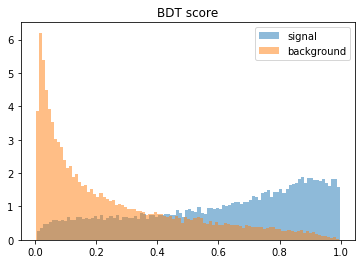

In [11]:

# *** see how the new model performs
param_new2 = {
    'learning_rate': 0.3,
    #'n_estimator': 1000,
    #'eta': 0.3,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param_new2)

In [12]:
# *** tune subsample and colsample_bytree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)]
    #'colsample_bytree':[0.9,1.0],
    #'subsample': [0.9,1.0]
}
gsearch4 = GridSearchCV(xgb.XGBClassifier(**param_new2), param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch4.cv_results_))
print("The best paramter: {}".format(gsearch4.best_params_))
#print("The best score: {}".format(gsearch4.best_score_))


/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'colsample_bytree': 0.9, 'subsample': 1.0}


In [ ]:
# *** tune alpha
param_test5 = {
    #'reg_alpha': [1e-05,1e-02,0.1,1,100],
    #'reg_lambda': [0,3,5,7,9]
    'reg_alpha': [0.7,1,1,2],
    'reg_lambda': [8,9,10]
}
param_new3 = {
    'learning_rate': 0.3,
    #'n_estimator': 1000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

gsearch5 = GridSearchCV(xgb.XGBClassifier(**param_new3), param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch5.cv_results_))
print("The best paramter: {}".format(gsearch5.best_params_))
#print("The best score: {}".format(gsearch5.best_score_))



In [8]:
_sw = getLumiScaleFactor( 0.3, _isDihiggs = True)
_bw = getLumiScaleFactor( 0.3, _isDihiggs = False)
e_sig = 1.57*M.sqrt(1/(1873.0/_sw) + 1/(4*(1418389.86/_bw)))
print(e_sig)

0.03584928797489655


In [5]:
'''

Original variables:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


parameter for 15 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


20 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1, 
    'reg_lambda': 10,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

40 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 3, 
    'reg_lambda': 5,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}



PCA:
15 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 6,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

20 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

40 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.5,
    'reg_alpha': 1, 
    'reg_lambda': 12,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
'''

"\nparameter for 15 clusters:\nparam_new4 = {\n    'eta': 0.1,\n    'n_estimator': 5000,\n    'max_depth': 11,\n    'min_child_weight': 0,\n    'subsample': 1.0,\n    'colsample_bytree': 0.8,\n    'gamma': 0,\n    'reg_alpha': 1, \n    'reg_lambda': 9,\n    'scale_pos_weight': 1,\n    'eval_metric': 'auc',\n    'objective': 'binary:logistic',\n    'random_state': 27\n}\n\n\n20 clusters:\nparam_new4 = {\n    'eta': 0.1,\n    'n_estimator': 5000,\n    'max_depth': 11,\n    'min_child_weight': 0,\n    'subsample': 1.0,\n    'colsample_bytree': 1.0,\n    'gamma': 0.5,\n    'reg_alpha': 1, \n    'reg_lambda': 10,\n    'scale_pos_weight': 1,\n    'eval_metric': 'auc',\n    'objective': 'binary:logistic',\n    'random_state': 27\n}\n\n40 clusters:\nparam_new4 = {\n    'eta': 0.1,\n    'n_estimator': 5000,\n    'max_depth': 11,\n    'min_child_weight': 0,\n    'subsample': 1.0,\n    'colsample_bytree': 1.0,\n    'gamma': 0.5,\n    'reg_alpha': 3, \n    'reg_lambda': 5,\n    'scale_pos_weight':

In [ ]:
# *** Plot the learning curve
plot_learning_curve(score_km_train_norm, labels_train_np, param, nClus)

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
#train the NN
nInputNodes = 3

model = Sequential()
model.add(Dense(10, input_dim=15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#history = model.fit(score_km_train_norm, labels_train, epochs=25, validation_split=0.25, batch_size=400)
history = model.fit(score_pcakm_train_norm, labels_train, epochs=25, validation_split=0.25, batch_size=400)

In [ ]:
history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])